# BIL401(Big Data) - Project
## Credit Card Fraud Detection
### Ömer Faruk Özgül(191101025) - Talha Çetin(201101036)

In [1]:
#Import Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Asıl dataset ile çalışmak için aşağıdaki kodu commentten çıkartın.
#df = pd.read_csv('dataset.csv')

# Asıl dataset ile çalışmak için aşağıdaki kodu siliniz.
df = pd.read_csv('subset.csv')

In [3]:
# # Asağıdaki kod subset oluşturmak için çalıştırılmıştır. 
# # DataFrame içinden rastgele bir alt küme seç
# subset = dataframe.sample(n=1000, random_state=1)  # random_state sabit bir örnek için kullanılır

# # Alt kümeyi bir CSV dosyasına kaydet
# subset.to_csv('subset_example.csv', index=False)

In [4]:
# Before Data Preprocessing
df.head(3)

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,413,1,2011,3,15,07:50,$50.43,Swipe Transaction,-3220758452254689706,Spokane,WA,99208.0,5311,NaN,No
1,433,1,2015,9,20,05:30,$53.78,Online Transaction,-2088492411650162548,ONLINE,NaN,NaN,4784,NaN,No
2,1442,3,2020,2,10,11:41,$30.98,Chip Transaction,-4113349227963201766,Lakeland,FL,33813.0,5411,NaN,No


## Data Preprocessing

In [5]:
# Is Fraud? değerini 1 ve 0 değerlerine dönüştürelim
df['Is Fraud?'] = df['Is Fraud?'].map({'Yes': 1, 'No': 0})

# Amount sütunundaki para birimi simgelerini kaldırıp sayısal bir formata dönüştürelim
df['Amount'] = df['Amount'].replace('[\$,]', '', regex=True).astype(float)

# Time sütununu tarih-zaman veri tipine dönüştürelim
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M').dt.time

In [6]:
# 'Errors?' sütunundaki eksik değerleri 'No Error' ile dolduralım
df['Errors?'].fillna('No Error', inplace=True)

# 'Merchant State' için en sık görülen değeri bulup eksik değerleri dolduruyoruz
# Bu, eksik verilerin rastgele dağıldığı ve dolandırıcılıkla ilişkili olmadığı tespitine dayanıyor.
# En sık görülen değer, veri setimizin gerçek dağılımını temsil eden bir değer olduğu için tercih edilmiştir.
most_common_state = df['Merchant State'].mode()[0]
df['Merchant State'].fillna(most_common_state, inplace=True)

# 'Zip' kodu için de benzer bir işlem yaparak eksik değerleri en sık görülen posta kodu ile dolduruyoruz.
# Bu yaklaşım, modelimizin eğitiminde tutarlılık sağlamak ve eksik veri kaynaklı önyargıları önlemek için kullanılır.
most_common_zip = df['Zip'].mode()[0]
df['Zip'].fillna(most_common_zip, inplace=True)


In [7]:
# After Data Preprocessing
df.head(3)

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,413,1,2011,3,15,07:50:00,50.43,Swipe Transaction,-3220758452254689706,Spokane,WA,99208.0,5311,No Error,0
1,433,1,2015,9,20,05:30:00,53.78,Online Transaction,-2088492411650162548,ONLINE,CA,48146.0,4784,No Error,0
2,1442,3,2020,2,10,11:41:00,30.98,Chip Transaction,-4113349227963201766,Lakeland,FL,33813.0,5411,No Error,0


In [8]:
df.describe()

,User,Card,Year,Month,Day,Amount,Merchant Name,Zip,MCC,Is Fraud?
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.00000,1000.000000,1000.000000
mean,981.479000,1.399000,2011.959000,6.495000,15.927000,46.989080,-5.280699e+17,51310.52600,5551.797000,0.002000
std,566.244762,1.438704,5.315974,3.554801,8.649537,91.032276,4.927588e+18,27871.29772,933.183637,0.044699
min,0.000000,0.000000,1993.000000,1.000000,1.000000,-494.000000,-9.172320e+18,1108.00000,1711.000000,0.000000
25%,489.750000,0.000000,2008.000000,3.000000,8.000000,9.385000,-4.752064e+18,30667.00000,5258.500000,0.000000
50%,966.000000,1.000000,2012.000000,7.000000,16.000000,29.465000,-1.288082e+18,48146.00000,5499.000000,0.000000
75%,1444.250000,2.000000,2016.000000,10.000000,24.000000,70.792500,3.414527e+18,76054.00000,5812.000000,0.000000
max,1997.000000,7.000000,2020.000000,12.000000,31.000000,1105.750000,9.204509e+18,99208.00000,9402.000000,1.000000


## (Exploratory Data Analysis - EDA) 

### 'IsFraud' Değerinin Dağılımı

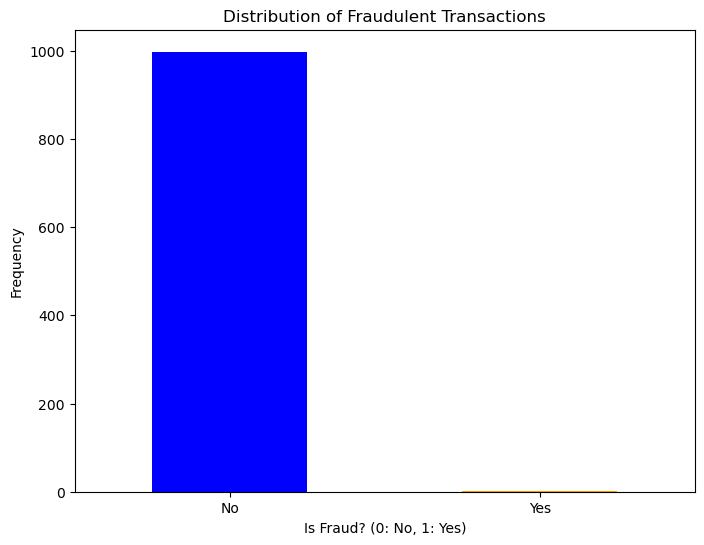

Frauds: 0.2 % of the dataset
No Frauds: 99.8 % of the dataset


In [9]:
fraud_counts = df['Is Fraud?'].value_counts()

# Dağılımı çubuk grafik olarak görselleştir
plt.figure(figsize=(8, 6))
fraud_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Fraudulent Transactions')
plt.xlabel('Is Fraud? (0: No, 1: Yes)')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)  # X eksenindeki etiketleri özelleştir
plt.show()

# Dataset dağılımında ciddi bir dengesizlik var mı diye kontrol et
fraud_count = df['Is Fraud?'].value_counts(normalize=True) * 100

# 'Is Fraud?' sütununun yüzdesel dağılımını hesaplayalım
fraud_percentage = df['Is Fraud?'].mean() * 100  # '1' dolandırıcılık, '0' normal işlem
nofraud_percentage = 100 - fraud_percentage
print('Frauds:', fraud_percentage, '% of the dataset')
print('No Frauds:', nofraud_percentage, '% of the dataset')

### Kategorik verilerin dağılımları

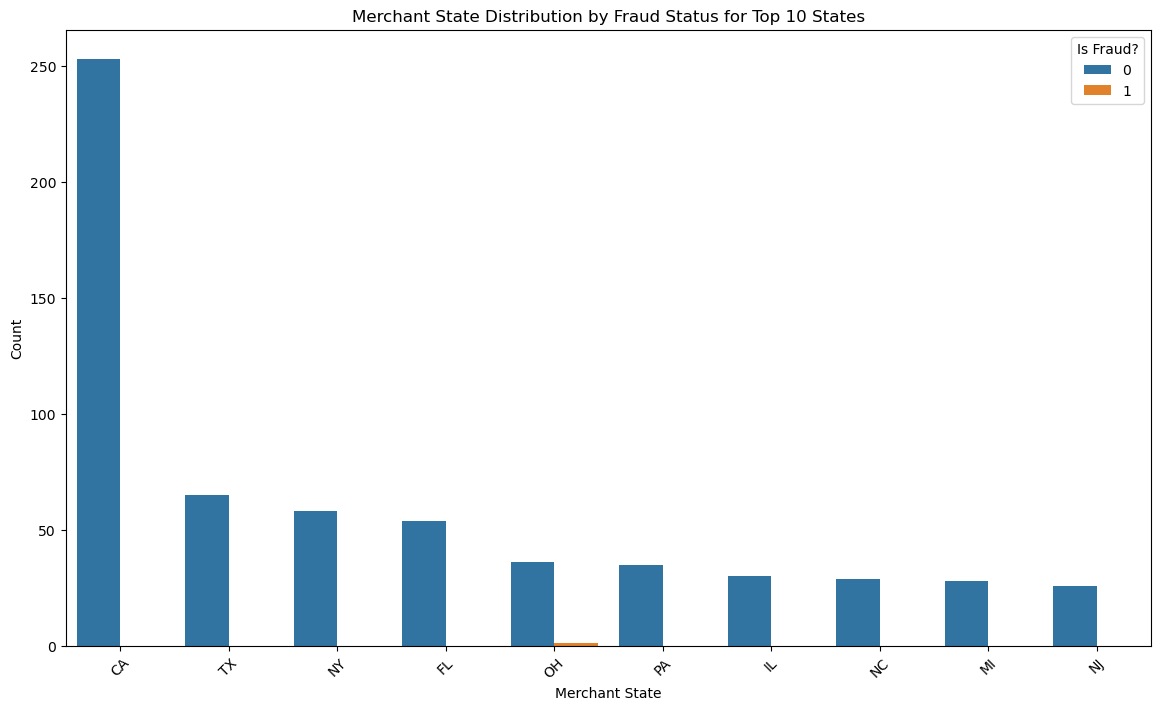

In [10]:

# 'Merchant State' sütununun dolandırıcılık durumlarına göre dağılımını görselleştirelim
# En sık görünen ilk 10 eyaleti alalım
top_states = df['Merchant State'].value_counts().head(10).index

# Sadece en sık görünen eyaletleri ve dolandırıcılık durumlarını içeren bir dataframe oluşturalım
top_states_df = df[df['Merchant State'].isin(top_states)]

plt.figure(figsize=(14, 8))
sns.countplot(data=top_states_df, x='Merchant State', hue='Is Fraud?', order=top_states)
plt.title('Merchant State Distribution by Fraud Status for Top 10 States')
plt.xlabel('Merchant State')
plt.ylabel('Count')
plt.legend(title='Is Fraud?', loc='upper right')
plt.xticks(rotation=45)  # Eyalet isimlerinin okunabilirliği için
plt.show()


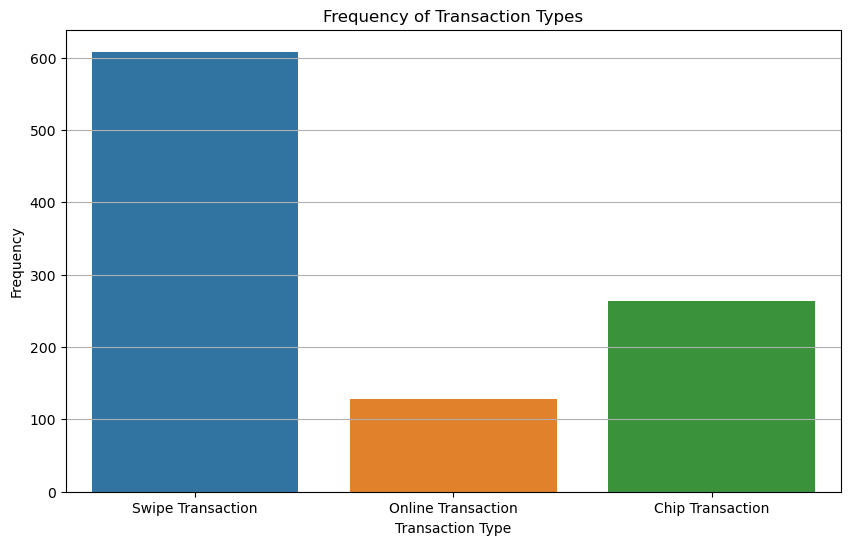

In [11]:
# 'Use Chip' sütununun frekanslarını inceleyelim ve görselleştirelim
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Use Chip')
plt.title('Frequency of Transaction Types')
plt.xlabel('Transaction Type')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

### Diğer değişkenlerin dağılımları

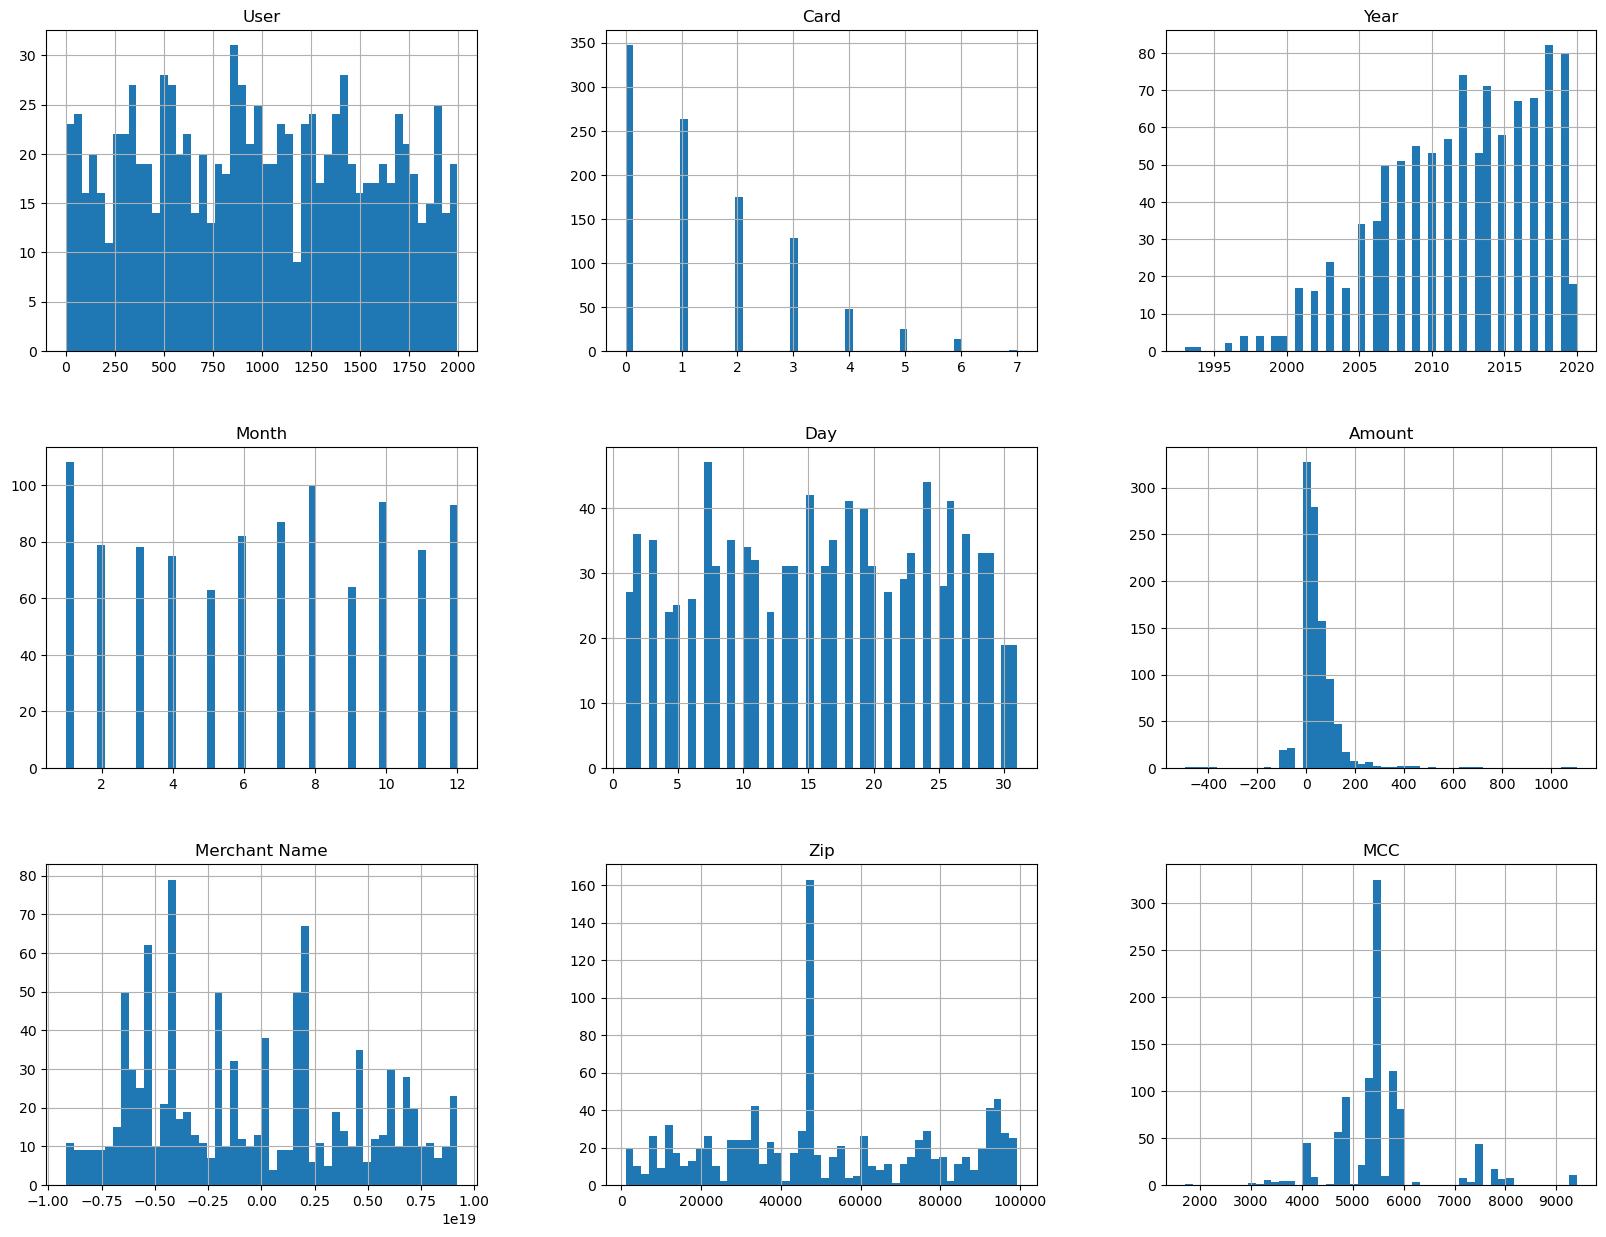

In [12]:
# 'Is Fraud?' değişkeni hariç diğer sürekli değişkenler için histogramlar çizelim
continuous_columns = df.select_dtypes(include=['float64', 'int64']).columns.drop('Is Fraud?')  # Is Fraud? sütunu hariç tutuluyor

df[continuous_columns].hist(bins=50, figsize=(20, 15))
plt.show()

### Korelasyon Matrisi

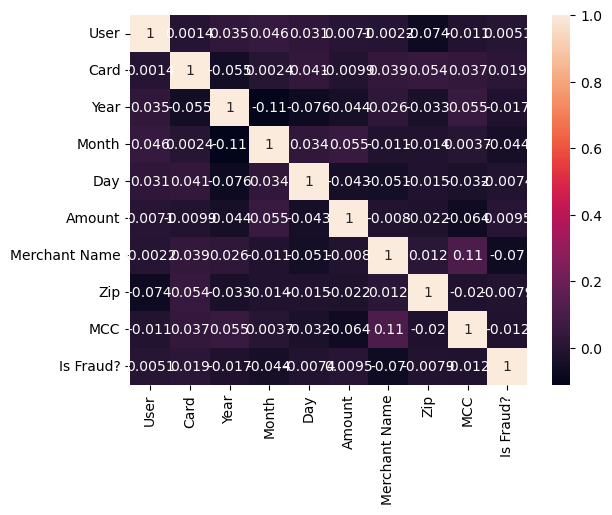

In [14]:
# Sürekli değişkenler arasındaki korelasyon
correlation_matrix = df.corr(numeric_only=True)

sns.heatmap(correlation_matrix, annot=True)
plt.show()